# Predicting NYC Taxi Fares with RAPIDS

[RAPIDS](https://rapids.ai/) is a suite of GPU accelerated data science libraries with APIs that should be familiar to users of Pandas, Dask, and Scikitlearn.

Anaconda has graciously made some of the NYC Taxi dataset available in [a public Google Cloud Storage bucket](https://console.cloud.google.com/storage/browser/anaconda-public-data/nyc-taxi/csv/).

This notebook builds a simple data pipeline to load the data with cuDF (or Pandas), analyze it with cuML (or scikit-learn), and then try some steps with multiple GPUs.

In [1]:
import os
import requests
from tqdm.auto import tqdm

def download(url, fname):
    response = requests.get(url, stream=True)
    with tqdm.wrapattr(
        open(fname, "wb"), "write",
        unit='B', unit_scale=True, unit_divisor=1024, miniters=1,
        desc=fname, total=int(response.headers.get('content-length', 0))
    ) as fout:
        for chunk in response.iter_content(chunk_size=4096):
            fout.write(chunk)

base = "https://d37ci6vzurychx.cloudfront.net/trip-data/"
for i in range(1, 13):
    fname = f"yellow_tripdata_2021-{i:02d}.parquet"
    if not os.path.exists(fname):
        download(base + fname, fname)

/home/ashwin/miniconda3/envs/all_cuda-118_arch-x86_64/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import pandas as pd
# import cuml
import cudf
import os

# Inspecting the Data

Let's start with a familiar Pandas approach then port it to RAPIDS in parallel

In [3]:
# FIXME
base_path = ''

In [4]:
%%time
# Pandas

df_2021 = pd.read_parquet(base_path+'yellow_tripdata_2021-01.parquet')
df_2021.head()

CPU times: user 759 ms, sys: 325 ms, total: 1.08 s
Wall time: 163 ms


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,1.0,N,142,43,2,8.0,3.0,0.5,0.00,0.0,0.3,11.80,2.5,NaN
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.20,1.0,N,238,151,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0,NaN
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,1.0,N,132,165,1,42.0,0.5,0.5,8.65,0.0,0.3,51.95,0.0,NaN
3,1,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,10.60,1.0,N,138,132,1,29.0,0.5,0.5,6.05,0.0,0.3,36.35,0.0,NaN
4,2,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,1.0,N,68,33,1,16.5,0.5,0.5,4.06,0.0,0.3,24.36,2.5,NaN


In [5]:
%%time
# TODO: Read the CSV with cudf into gdf_2021

gdf_2021 = cudf.read_parquet(base_path+'yellow_tripdata_2021-01.parquet')
gdf_2021.head()

CPU times: user 1.15 s, sys: 831 ms, total: 1.98 s
Wall time: 1.93 s


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,1.0,N,142,43,2,8.0,3.0,0.5,0.00,0.0,0.3,11.80,2.5,<NA>
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.20,1.0,N,238,151,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0,<NA>
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,1.0,N,132,165,1,42.0,0.5,0.5,8.65,0.0,0.3,51.95,0.0,<NA>
3,1,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,10.60,1.0,N,138,132,1,29.0,0.5,0.5,6.05,0.0,0.3,36.35,0.0,<NA>
4,2,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,1.0,N,68,33,1,16.5,0.5,0.5,4.06,0.0,0.3,24.36,2.5,<NA>


# Data Cleanup

As usual, the data needs to be massaged a bit before we can start adding features that are useful to an ML model.

For example, in the 2014 taxi CSV files, there are `pickup_datetime` and `dropoff_datetime` columns.

Also, some CSV files have column names with extraneous spaces in them.

We'll do a little string manipulation, column renaming, and concatenating of DataFrames to sidestep the problems.

In [6]:
# list of column names that need to be re-mapped
remap = {
    'tpep_pickup_datetime': 'pickup_datetime',
    'tpep_dropoff_datetime': 'dropoff_datetime',
    'ratecodeid': 'rate_code',
    'pulocationid': 'pickup_location',
    'dolocationid': 'dropoff_location'
}

# create a list of columns & dtypes the df must have
# note that float64 will be significantly slower on some GPUs (most GeForce, also Tesla T4)
must_haves = {
    'pickup_datetime': 'datetime64[ms]',
    'dropoff_datetime': 'datetime64[ms]',
    'passenger_count': 'int32',
    'trip_distance': 'float',
    'pickup_longitude': 'float',
    'pickup_latitude': 'float',
    'rate_code': 'int32',
    'dropoff_longitude': 'float',
    'dropoff_latitude': 'float',
    'fare_amount': 'float',
    'pickup_location': 'int32',
    'dropoff_location': 'int32'
}

In [7]:
# helper function which takes a DataFrame and fixes column types
def clean_columns(df_part, remap, must_haves):    
    # iterate through columns in this df
    for col in df_part.columns:
        # drop anything not in our expected list
        if col not in must_haves:
            print(f"Dropping ({col})")
            df_part = df_part.drop(columns=col)
            continue
        if df_part[col].dtype.kind in {'i', 'f'}:
            df_part[col] = df_part[col].fillna(-1)
        df_part[col] = df_part[col].astype(must_haves[col])
    return df_part

In [8]:
%%time
# Pandas approach

# some col-names include pre-pended spaces remove & lowercase column names
col_cleanup = {col: col.strip().lower() for col in list(df_2021.columns)}
df = df_2021.rename(columns=col_cleanup)
# rename columns using the supplied mapping
df = df.rename(remap, axis=1)

df = clean_columns(df, remap, must_haves)
print(df.__class__)
df.head()

Dropping (vendorid)
Dropping (store_and_fwd_flag)
Dropping (payment_type)
Dropping (extra)
Dropping (mta_tax)
Dropping (tip_amount)
Dropping (tolls_amount)
Dropping (improvement_surcharge)
Dropping (total_amount)
Dropping (congestion_surcharge)
Dropping (airport_fee)
<class 'pandas.core.frame.DataFrame'>
CPU times: user 527 ms, sys: 213 ms, total: 740 ms
Wall time: 729 ms


,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,pickup_location,dropoff_location,fare_amount
0,2021-01-01 00:30:10,2021-01-01 00:36:12,1,2.10,1,142,43,8.0
1,2021-01-01 00:51:20,2021-01-01 00:52:19,1,0.20,1,238,151,3.0
2,2021-01-01 00:43:30,2021-01-01 01:11:06,1,14.70,1,132,165,42.0
3,2021-01-01 00:15:48,2021-01-01 00:31:01,0,10.60,1,138,132,29.0
4,2021-01-01 00:31:49,2021-01-01 00:48:21,1,4.94,1,68,33,16.5


In [9]:
%%time
# TODO: RAPIDS approach - same as aPandas, but generate 'gdf' as output
# some col-names include pre-pended spaces remove & lowercase column names
col_cleanup = {col: col.strip().lower() for col in list(gdf_2021.columns)}
gdf = gdf_2021.rename(columns=col_cleanup)
# rename columns using the supplied mapping
gdf = gdf.rename(remap, axis=1)

gdf = clean_columns(gdf, remap, must_haves)
print(gdf.__class__)
gdf.head()

Dropping (vendorid)
Dropping (store_and_fwd_flag)
Dropping (payment_type)
Dropping (extra)
Dropping (mta_tax)
Dropping (tip_amount)
Dropping (tolls_amount)
Dropping (improvement_surcharge)
Dropping (total_amount)
Dropping (congestion_surcharge)
Dropping (airport_fee)
<class 'cudf.core.dataframe.DataFrame'>
CPU times: user 21.1 ms, sys: 59.8 ms, total: 80.9 ms
Wall time: 90 ms


,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,pickup_location,dropoff_location,fare_amount
0,2021-01-01 00:30:10,2021-01-01 00:36:12,1,2.10,1,142,43,8.0
1,2021-01-01 00:51:20,2021-01-01 00:52:19,1,0.20,1,238,151,3.0
2,2021-01-01 00:43:30,2021-01-01 01:11:06,1,14.70,1,132,165,42.0
3,2021-01-01 00:15:48,2021-01-01 00:31:01,0,10.60,1,138,132,29.0
4,2021-01-01 00:31:49,2021-01-01 00:48:21,1,4.94,1,68,33,16.5


# Look at some key stats

In [10]:
import seaborn as sns

<AxesSubplot: xlabel='passenger_count', ylabel='fare_amount'>

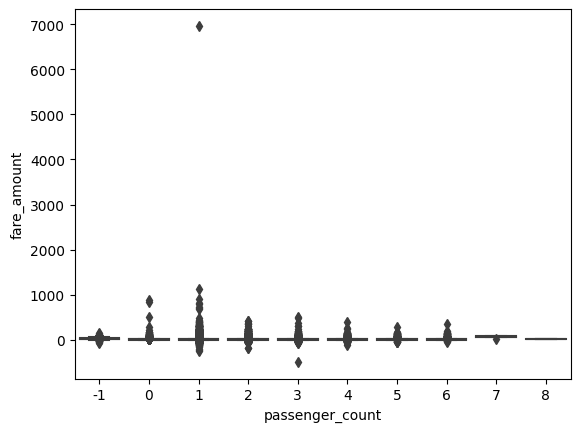

In [11]:
sns.boxplot(x="passenger_count", y="fare_amount", data=df)

# Filter the data

In [12]:
%%time

# apply a list of filter conditions to throw out records with missing or outlier values
query_frags = [
    'fare_amount > 0 and fare_amount < 500',
    'passenger_count > 0 and passenger_count < 6',
]
df_subset = df.query(' and '.join(query_frags)).copy()

# inspect the results of cleaning
df_subset.head()

CPU times: user 92.3 ms, sys: 23.9 ms, total: 116 ms
Wall time: 112 ms


,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,pickup_location,dropoff_location,fare_amount
0,2021-01-01 00:30:10,2021-01-01 00:36:12,1,2.10,1,142,43,8.0
1,2021-01-01 00:51:20,2021-01-01 00:52:19,1,0.20,1,238,151,3.0
2,2021-01-01 00:43:30,2021-01-01 01:11:06,1,14.70,1,132,165,42.0
4,2021-01-01 00:31:49,2021-01-01 00:48:21,1,4.94,1,68,33,16.5
5,2021-01-01 00:16:29,2021-01-01 00:24:30,1,1.60,1,224,68,8.0


In [13]:
%%time

# TODO: RAPIDS version with "gdf_subset" as output

# apply a list of filter conditions to throw out records with missing or outlier values
query_frags = [
    'fare_amount > 0 and fare_amount < 500',
    'passenger_count > 0 and passenger_count < 6',
]
gdf_subset = gdf.query(' and '.join(query_frags)).copy()

# inspect the results of cleaning
gdf_subset.head()

CPU times: user 317 ms, sys: 10.4 ms, total: 328 ms
Wall time: 322 ms


,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,pickup_location,dropoff_location,fare_amount
0,2021-01-01 00:30:10,2021-01-01 00:36:12,1,2.10,1,142,43,8.0
1,2021-01-01 00:51:20,2021-01-01 00:52:19,1,0.20,1,238,151,3.0
2,2021-01-01 00:43:30,2021-01-01 01:11:06,1,14.70,1,132,165,42.0
4,2021-01-01 00:31:49,2021-01-01 00:48:21,1,4.94,1,68,33,16.5
5,2021-01-01 00:16:29,2021-01-01 00:24:30,1,1.60,1,224,68,8.0


# Demo 3: UDFs to add rich features 

cuDF provides standard DataFrame operations, but also let you run "user defined functions" on the underlying data.

cuDF's [apply_rows](https://rapidsai.github.io/projects/cudf/en/0.6.0/api.html#cudf.dataframe.DataFrame.apply_rows) operation is similar to Pandas's [DataFrame.apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html), except that for cuDF, custom Python code is [JIT compiled by numba](https://numba.pydata.org/numba-doc/dev/cuda/kernels.html) into GPU kernels.

We'll use a Haversine Distance calculation to find total trip distance, and extract additional useful variables from the datetime fields.

In [14]:
from numpy import pi

# FIXME: Add a feature via UDF

def add_features(df):
    df['hour'] = df['pickup_datetime'].dt.hour
    df['year'] = df['pickup_datetime'].dt.year
    df['month'] = df['pickup_datetime'].dt.month
    df['day'] = df['pickup_datetime'].dt.day
    
    df["day_of_week"] = df["pickup_datetime"].dt.dayofweek
    
    df = df.drop(columns=['pickup_datetime', 'dropoff_datetime'])    
    
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(np.int32)
    return df

In [15]:
%%time

# actually add the features
taxi_df = add_features(df_subset)
taxi_df

CPU times: user 428 ms, sys: 10.8 ms, total: 439 ms
Wall time: 433 ms


,passenger_count,trip_distance,rate_code,pickup_location,dropoff_location,fare_amount,hour,year,month,day,day_of_week,is_weekend
0,1,2.10,1,142,43,8.0,0,2021,1,1,4,0
1,1,0.20,1,238,151,3.0,0,2021,1,1,4,0
2,1,14.70,1,132,165,42.0,0,2021,1,1,4,0
4,1,4.94,1,68,33,16.5,0,2021,1,1,4,0
5,1,1.60,1,224,68,8.0,0,2021,1,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1271412,3,0.81,1,41,74,5.0,23,2021,1,31,6,1
1271413,1,3.81,1,113,141,12.5,23,2021,1,31,6,1
1271414,1,1.32,1,233,237,6.0,23,2021,1,31,6,1
1271415,2,10.56,1,56,68,37.5,23,2021,1,31,6,1


## cuDF version with UDF

cuDF's [apply_rows](https://rapidsai.github.io/projects/cudf/en/0.6.0/api.html#cudf.dataframe.DataFrame.apply_rows) operation is similar to Pandas's [DataFrame.apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html), except that for cuDF, custom Python code is [JIT compiled by numba](https://numba.pydata.org/numba-doc/dev/cuda/kernels.html) into GPU kernels.

In [16]:
%%time

# TODO: actually add the features and create "taxi_gdf" from gdf_subset
taxi_gdf = add_features(gdf_subset)
taxi_gdf

CPU times: user 11.1 ms, sys: 7.83 ms, total: 18.9 ms
Wall time: 16 ms


,passenger_count,trip_distance,rate_code,pickup_location,dropoff_location,fare_amount,hour,year,month,day,day_of_week,is_weekend
0,1,2.10,1,142,43,8.0,0,2021,1,1,4,0
1,1,0.20,1,238,151,3.0,0,2021,1,1,4,0
2,1,14.70,1,132,165,42.0,0,2021,1,1,4,0
4,1,4.94,1,68,33,16.5,0,2021,1,1,4,0
5,1,1.60,1,224,68,8.0,0,2021,1,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1271412,3,0.81,1,41,74,5.0,23,2021,1,31,6,1
1271413,1,3.81,1,113,141,12.5,23,2021,1,31,6,1
1271414,1,1.32,1,233,237,6.0,23,2021,1,31,6,1
1271415,2,10.56,1,56,68,37.5,23,2021,1,31,6,1


For more advanced spatial calculations, check out cuSpatial (https://medium.com/rapids-ai/releasing-cuspatial-to-accelerate-geospatial-and-spatiotemporal-processing-b686d8b32a9), the newest RAPIDS library.

In [17]:
# TODO: Print summary stats from "taxi_gdf"

# Pick a Training Set

Let's imagine you're making a trip to New York on the 24th and want to build a model to predict what fare prices will be like the last few days of the month based on the first part of the month. We'll use a query expression to identify the `day` of the month to use to divide the data into train and test sets.

The wall-time below represents how long it takes your GPU cluster to load data from the Google Cloud Storage bucket and the ETL portion of the workflow.

In [18]:
%%time
X_train_df = taxi_df.query('day < 24')
Y_train_df = X_train_df[['fare_amount']]
X_train_df = X_train_df.drop(columns='fare_amount')

# numpy versions for sklearn
X_train_np = X_train_df.to_numpy()
Y_train_np = Y_train_df.to_numpy()
len(X_train_df)

CPU times: user 87.5 ms, sys: 56.6 ms, total: 144 ms
Wall time: 140 ms


892229

In [19]:
from cuml.utils import input_utils # Helpful functions for managing gpu arrays

ModuleNotFoundError: No module named 'cuml'

In [ ]:
%%time
X_train_gdf = taxi_gdf.query('day < 24')
Y_train_gdf = X_train_gdf[['fare_amount']]
X_train_gdf = X_train_gdf.drop(columns='fare_amount')

# gpu matrix versions for cuml
X_train_gpu = input_utils.input_to_dev_array(X_train_gdf, convert_to_dtype=np.float32).array
Y_train_gpu = input_utils.input_to_dev_array(Y_train_gdf, convert_to_dtype=np.float32).array

# test versions
X_test_gdf = taxi_gdf.query('day >= 24')
Y_test_gdf = X_test_gdf[['fare_amount']]
X_test_gdf = X_test_gdf.drop(columns='fare_amount')

X_test_gpu = input_utils.input_to_dev_array(X_test_gdf, convert_to_dtype=np.float32).array
Y_test_gpu = input_utils.input_to_dev_array(Y_test_gdf, convert_to_dtype=np.float32).array


len(X_train_gdf)

# Demo 4: Cluster and analyze with cuML

In [ ]:
%matplotlib inline

In [ ]:
import sklearn, sklearn.cluster
from matplotlib import pyplot as plt

In [ ]:
%%time
# use scikit-learn on CPU

sk_kmeans = sklearn.cluster.KMeans(n_clusters=5, n_jobs=-1)
train_clusters_cpu = sk_kmeans.fit_predict(X_train_np[:200000,:])

In [ ]:
%%time
n_samples = 400000

# TODO: use cuML on GPU to fit KMeans with 5 clusters (larger dataset)

In [ ]:
# Just take a subset to speed plotting
gdf_train_head = X_train_gdf.iloc[:400000]
gdf_train_head["cluster"] = train_clusters_gpu[:400000]
gdf_train_head["short_trip"] = gdf_train_head["trip_distance"] < 1.01 # About the 25th percentile
gdf_train_head["is_rush_est"] = ((gdf_train_head.hour >= 10) & (gdf_train_head.hour <= 14)) | \
                                ((gdf_train_head.hour >= 21) & (gdf_train_head.hour <= 24))

# actually do the plot
sns.lmplot("pickup_longitude", "pickup_latitude", data=gdf_train_head.to_pandas(),
           hue="cluster", col="is_rush_est", row="short_trip", fit_reg=False, scatter_kws={"s": 10})

### Fit a simple supervised model with cuML

cuML supports a large range of supervised models, all emulating the scikit-learn interfaces. See the README (https://github.com/rapidsai/cuml) for a recent list. Here, we'll try a very simple model - a regularized linear regression with the ElasticNet approach that blends L1 and L2 penalties.

In [ ]:
from sklearn.linear_model import ElasticNet as skElastic
from cuml.linear_model import ElasticNet as cuElastic

In [ ]:
%%time
# Sklearn will parallelize over all CPU cores with n_jobs=-1
sk_model = skElastic(alpha=0.1)
sk_model.fit(X_train_np, Y_train_np)

In [ ]:
%%time

# TODO: Build a similar model on GPU with cuML

In [ ]:
%%time

# Predict on a test set (storing as "enet_predictions" in the Y_test_gdf df)
# and evaluate the predictions' R2 score

# Demo 5: Train an  XGBoost Regression Model

XGBoost is one of the most popular packages for gradient boosted decision trees. It comes with excellent GPU acceleration out of the box.

In [ ]:
%%time
# Train on CPU (uses all CPUs by default)
import xgboost

params = {
 'learning_rate': 0.3,
  'max_depth': 6,

  'subsample': 0.6,
  'gamma': 1
}

train_dmat = xgboost.DMatrix(X_train_np, Y_train_np, feature_names=X_train_df.columns)
print("Converted to dmatrix")
trained_model = xgboost.train(params, train_dmat, num_boost_round=5)

In [ ]:
%%time
# TODO: retrain on GPU for more rounds, saving model as trained_model_gpus

# How Good is Our Model?

Now that we have a trained model, we need to test it with the ecords we held out.

In [ ]:
%%time

# TODO: generate predictions on the test set as Y_test_gdf['prediction']

# Compute Root Mean Squared Error

In [ ]:
Y_test_gdf["squared_error"] = (Y_test_gdf['prediction'] - Y_test_gdf['fare_amount'])**2

# inspect the results to make sure our calculation looks right
Y_test_gdf.head()

In [ ]:
# compute the actual RMSE over the full test set
np.sqrt(Y_test_gdf.squared_error.mean())

# Save Trained Model for Later Use

To make a model maximally useful, you need to be able to save it for later use.

In [ ]:
# Save model
trained_model_gpu.save_model("output.model")

# Demo 6: A quick intro to Dask + RAPIDS

Dask is a sophisticated package for parallel computation with a number of different datatypes. For much more detail, see: https://tutorial.dask.org/

In these examples, we'll focus on the basics of `dask_cudf` and `dask_cuda`

In [ ]:
import dask_cudf

In [ ]:
import dask, dask_cudf
from dask_cuda import LocalCUDACluster
from dask.distributed import Client, wait

In [ ]:
# Setup a cluster and connect a client to it

cluster = LocalCUDACluster()
client = Client(cluster)

In [ ]:
client

In [ ]:
%%time
ddf_all2014 = dask_cudf.read_csv(base_path+'2014/yellow_*.csv')

In [ ]:
len(ddf_all2014)

In [ ]:
# Redo the same cleanup we used above but on Dask this time

col_cleanup = {col: col.strip().lower() for col in list(df_2014.columns)}
ddf = ddf_all2014.rename(columns=col_cleanup)
# rename columns using the supplied mapping
ddf = ddf.rename(columns=remap)

ddf = clean_columns(ddf, remap, must_haves, np.float64)

In [ ]:
# Compute a simple histogram of passengers

value_counts = ddf.passenger_count.value_counts()
print(value_counts)
print(value_counts.compute())

## Machine learning with Dask

See also XGBoost's Dask interface docs: https://github.com/dmlc/xgboost/tree/master/demo/dask

In [ ]:
# Use map_partitions to apply the same distance function we used before
ddf_with_dist = ddf.map_partitions(compute_distance_gpu)
ddf_with_dist.head()

In [ ]:
kmeans_cols = ["passenger_count", "trip_distance", "rate_code", "fare_amount", "h_distance"]

In [ ]:
%%time
X_ddf = ddf_with_dist[kmeans_cols]
for c in X_ddf.columns:
    X_ddf[c] = X_ddf[c].astype(np.float32)
Y_ddf = X_ddf["fare_amount"]
X_ddf = X_ddf.drop(columns="fare_amount")

X_ddf, y_ddf = client.persist([X_ddf, Y_ddf]) # Trigger the computation and cache in RAM
_ = wait([X_ddf, y_ddf]) # Actually wait for persistence to finish

In [ ]:
import xgboost
from xgboost.dask import DaskDMatrix

In [ ]:
%%time

params = {'verbosity': 2, 'nthread': 1, 'tree_method': 'gpu_hist', 'objective': 'reg:squarederror',}

# TODO: create a dmatrix, train a model, and store as xgb_model

In [ ]:
# TODO: explore within-train-sample predictions